Learning to rank.

In [1]:
# set up Python
import logging
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import json
from plotnine import *
from wvu.util import plot_roc, threshold_plot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(383432)

In [3]:
example_name = 'uci wine example'

In [4]:
print(example_name)

uci wine example


In [5]:
if example_name=='uci wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('uci_wine_example_features.csv')
    features_scores = pd.read_csv('uci_wine_example_scores.csv')
    m_examples : int = 1000
    noise_scale = 8.7
    position_penalty_scale = -12.123
    simulation_sigma = 10.0
elif example_name=='sklearn wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('sklearn_wine_example_features.csv')
    features_scores = pd.read_csv('sklearn_wine_example_scores.csv')
    m_examples : int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
    simulation_sigma = 10.0
else:
    raise("bad option")



In [6]:
features_frame.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
features_frame.shape

(6497, 11)

In [8]:


features_scores.head()

,score
0,10.177865
1,9.856330
2,10.241983
3,12.145984
4,10.177865


In [9]:

n_alternatives : int = 5

In [10]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -12.123, -24.246, -36.369, -48.492]

In [11]:


n_vars : int = features_frame.shape[1] + len(position_penalties)


In [12]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f'display_position_{sel_i}'] = [sel_i] * m_examples
    selected_examples = rng.choice(features_frame.shape[0], size=m_examples, replace=True)
    observations[f'item_id_{sel_i}'] = selected_examples
    observations[f'score_value_{sel_i}'] = [  # noisy observation of score plus position penalty
        features_scores.loc[int(selected_examples[i]), 'score']                  # item score
        + position_penalties[sel_i] * rng.uniform(size=1, low=0, high=2)[0]  # positional penalty
        + noise_scale * rng.normal(size=1)[0]                                # observation noise
        for i in range(m_examples)
    ]
    observations[f'pick_value_{sel_i}'] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if observations[f'score_value_{j}'][i] > observations[f'score_value_{best_j}'][i]:
            best_j = j
    observations.loc[i, f'pick_value_{best_j}'] = 1

observations.head()

,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,4851,12.954273,1,1,1432,9.507258,0,2,1827,-11.933994,0,3,1388,1.712298,0,4,4494,-67.334614,0
1,0,1458,24.793973,1,1,4841,-10.316869,0,2,6102,-16.193391,0,3,1376,-7.174520,0,4,2797,-22.882694,0
2,0,4943,18.070494,1,1,4421,12.851216,0,2,4744,-22.007501,0,3,4982,-25.629352,0,4,2408,-71.539386,0
3,0,1900,10.926330,1,1,1315,-9.011167,0,2,1976,2.899534,0,3,68,-45.134301,0,4,4583,-16.114879,0
4,0,5569,18.295666,1,1,1001,18.152934,0,2,1868,-14.857479,0,3,5103,-39.674409,0,4,2704,-32.096879,0


In [13]:
observations.loc[:, [c for c in observations.columns if c.startswith('pick_value_')]].mean(axis=0)

pick_value_0    0.682
pick_value_1    0.163
pick_value_2    0.065
pick_value_3    0.041
pick_value_4    0.049
dtype: float64

In [14]:
observations[
    [c for c in observations.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head(10)

,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,1,1,0,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,1,1,0,2,0,3,0,4,0
3,0,1,1,0,2,0,3,0,4,0
4,0,1,1,0,2,0,3,0,4,0
5,0,0,1,1,2,0,3,0,4,0
6,0,0,1,1,2,0,3,0,4,0
7,0,0,1,1,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,1,1,0,2,0,3,0,4,0


In [15]:
# swap all observed alternatives selections into picked position
observations_sorted = observations.copy()
for passed_i in range(1, n_alternatives):
    for row_i in range(m_examples):
        if observations_sorted.loc[row_i, f'pick_value_{passed_i}'] > 0:
            # swap where data is stored in row
            for dest_col, source_col in (
                ('display_position_0', f'display_position_{passed_i}'),
                ('item_id_0', f'item_id_{passed_i}'),
                ('score_value_0', f'score_value_{passed_i}'),
                ('pick_value_0', f'pick_value_{passed_i}'),
                ):
                v_source = observations_sorted.loc[row_i, source_col]
                v_dest = observations_sorted.loc[row_i, dest_col]
                observations_sorted.loc[row_i, source_col] = v_dest
                observations_sorted.loc[row_i, dest_col] = v_source


In [16]:
observations_sorted.head(10)


,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,4851,12.954273,1,1,1432,9.507258,0,2,1827,-11.933994,0,3,1388,1.712298,0,4,4494,-67.334614,0
1,0,1458,24.793973,1,1,4841,-10.316869,0,2,6102,-16.193391,0,3,1376,-7.174520,0,4,2797,-22.882694,0
2,0,4943,18.070494,1,1,4421,12.851216,0,2,4744,-22.007501,0,3,4982,-25.629352,0,4,2408,-71.539386,0
3,0,1900,10.926330,1,1,1315,-9.011167,0,2,1976,2.899534,0,3,68,-45.134301,0,4,4583,-16.114879,0
4,0,5569,18.295666,1,1,1001,18.152934,0,2,1868,-14.857479,0,3,5103,-39.674409,0,4,2704,-32.096879,0
5,1,3567,16.426385,1,0,1997,7.962495,0,2,3196,-6.189384,0,3,6052,-58.278304,0,4,1229,-44.066868,0
6,1,2266,8.520404,1,0,4473,5.096899,0,2,5379,1.615527,0,3,6205,5.584532,0,4,6465,-6.032380,0
7,1,5413,0.498853,1,0,959,-6.822181,0,2,3090,-16.066309,0,3,3825,-25.020475,0,4,973,-37.995199,0
8,0,4516,14.320579,1,1,4814,-11.662619,0,2,5939,-3.372116,0,3,4806,3.207351,0,4,5069,-3.339519,0
9,0,933,22.470158,1,1,1096,-6.914114,0,2,6092,5.869372,0,3,927,-49.249274,0,4,4342,-14.598016,0


In [17]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head()

,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,1,1,0,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,1,1,0,2,0,3,0,4,0
3,0,1,1,0,2,0,3,0,4,0
4,0,1,1,0,2,0,3,0,4,0


In [18]:
assert np.all(observations_sorted['pick_value_0'] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f'pick_value_{sel_i}'] == 0)

In [19]:
stan_model_src = (
"""
data {
  int<lower=1> n_vars;                    // number of variables per alternative
  int<lower=1> m_examples;                // number of examples
  matrix[m_examples, n_vars] x_picked;    // character of picked examples
"""
  + ''.join([f"""  matrix[m_examples, n_vars] x_passed_{i};  // character of passed examples
""" for i in range(1, n_alternatives)])
  + """}
parameters {
  vector[n_vars] beta;                    // model parameters
  vector[m_examples] error_picked;        // noise term on picks
}
transformed parameters {
  vector[m_examples] v_picked;
"""
  + ''.join([f"""  vector[m_examples] expect_passed_{i};
""" for i in range(1, n_alternatives)])
  + """  v_picked = x_picked * beta + error_picked;
"""
  + ''.join([f"""  expect_passed_{i} = x_passed_{i} * beta;
""" for i in range(1, n_alternatives)])
  +"""}
model {
    // basic priors
  beta ~ normal(0, 10);
  error_picked ~ normal(0, 10);
    // log probability observed ordering
"""
  + ''.join([f"""  target += normal_lcdf( v_picked | expect_passed_{i}, 10);
""" for i in range(1, n_alternatives)])
  + """}
"""
)
stan_file = 'rank_src_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)

print(stan_model_src)


data {
  int<lower=1> n_vars;                    // number of variables per alternative
  int<lower=1> m_examples;                // number of examples
  matrix[m_examples, n_vars] x_picked;    // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;  // character of passed examples
}
parameters {
  vector[n_vars] beta;                    // model parameters
  vector[m_examples] error_picked;        // noise term on picks
}
transformed parameters {
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  v_picked = x_picked * beta + error_picked;
  expect_passed_1 = x_passed_1 * beta;
  expect_passed_2 = x_passed_2 * beta;
  

In [20]:
def fmt_array(a) -> str:
    return json.dumps([v for v in a])

def mk_posn_indicator(posn: int) -> str:
    posn_indicators = [0] * n_alternatives
    posn_indicators[posn] = 1
    return posn_indicators

def f_i(sel_i: int) -> str:
    id_seq = observations_sorted[f'item_id_{sel_i}']
    posn_seq = observations_sorted[f'display_position_{sel_i}']
    return fmt_array([
        list(features_frame.loc[int(id), :]) + mk_posn_indicator(int(posn))
        for id, posn in zip(id_seq, posn_seq)])

data_str = (f"""
{{
 "n_vars" : {n_vars},
 "m_examples" : {m_examples},
 "x_picked" : {f_i(0)},
"""
    + """,
""".join([f""" "x_passed_{i}" : {f_i(i)}""" for i in range(1, n_alternatives)])
    + """
}
"""
)

data_file = "rank_data_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [21]:
# build model

# instantiate the model object
model = CmdStanModel(stan_file=stan_file)
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
)

In [22]:
# get implied sample weights from chain
# this is double-counting weights as we would expect how often a sample path occurs to already
# encode probability. But we are seeing clearly not in the sweet spot chains that we must prune
# out. Their probabilities are so low, that if they were indeed being sample proportional to their
# probabilities- they just would not be here.
wt_frame = fit.draws_pd(vars=['lp__'])
log_wt = wt_frame['lp__'] - np.max(wt_frame['lp__'])
row_sample_wt = log_wt >= -10 * np.log(wt_frame.shape[0])  # threshold, a little more reasonable than np.exp(log_wt)
row_sample_wt = row_sample_wt / np.sum(row_sample_wt)
wt_frame['row_sample_wt'] = row_sample_wt


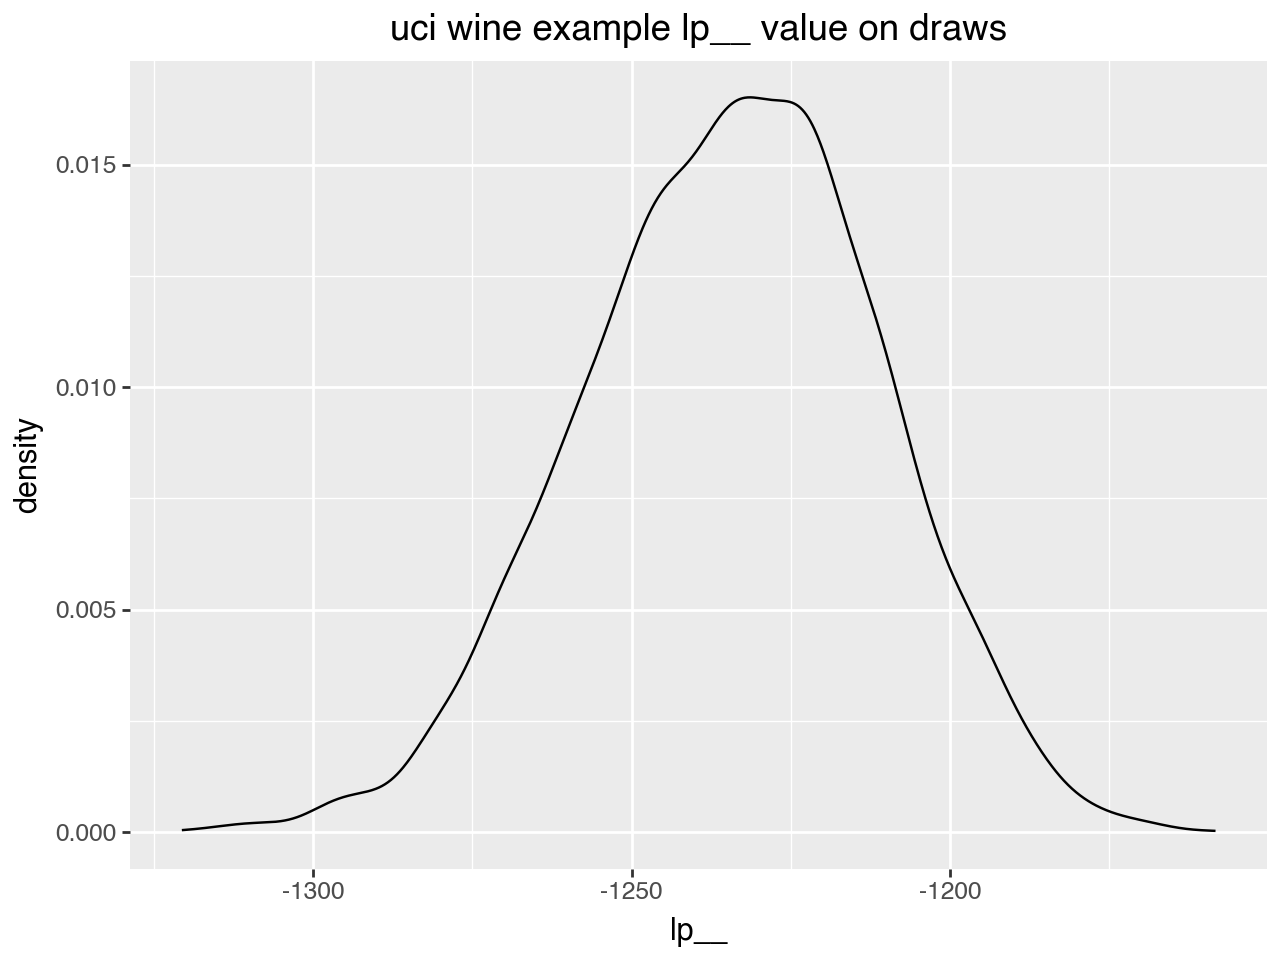

In [23]:
(
    ggplot(
        data=wt_frame,
        mapping=aes(x='lp__'),
    )
    + geom_density()
    + ggtitle(f'{example_name} lp__ value on draws')
)

In [24]:
estimated_beta = np.array(fit.draws_pd(vars=['beta']).mul(row_sample_wt, axis=0).sum())

In [25]:
estimated_beta

array([-2.87247169e-01, -5.16955759e+00, -1.16033878e+00,  4.35437936e-02,
       -1.08357170e+00, -6.72790115e-03,  5.42843481e-03, -2.60070947e-01,
        2.02778246e+00,  4.17208210e+00,  1.13317380e+00,  1.39063468e+01,
        2.17088308e+00, -3.59293504e+00, -6.07038189e+00, -5.16230908e+00])

In [26]:
estimated_scores = pd.DataFrame({
    'estimated score': features_frame @ estimated_beta[range(features_frame.shape[1])],
    })


In [27]:
position_effects_frame = pd.DataFrame({
    'position': [f'posn_{i}' for i in range(len(position_penalties))],
    'actual effect': position_penalties,
    'estimated effect': estimated_beta[features_frame.shape[1]:len(estimated_beta)],
})

position_effects_frame

,position,actual effect,estimated effect
0,posn_0,-0.000,13.906347
1,posn_1,-12.123,2.170883
2,posn_2,-24.246,-3.592935
3,posn_3,-36.369,-6.070382
4,posn_4,-48.492,-5.162309


In [28]:
def p_select(row_i: int):
    n_draws: int  = 10000
    est_row = [
        estimated_scores.loc[int(observations.loc[row_i, f'item_id_{sel_i}']), 'estimated score']  # estimated per item score
        + position_effects_frame.loc[sel_i, 'estimated effect']                                    # estimated position effect
        for sel_i in range(n_alternatives)]
    est_picks = [0] * n_alternatives
    est_picks[np.argmax(est_row)] = 1
    draws = pd.DataFrame({
        f'est_{i}': rng.normal(loc=est_row[i], scale=simulation_sigma, size=n_draws) for i in range(n_alternatives)
    })
    draws_maxes = draws.max(axis=1)
    draws = pd.DataFrame({
        k: draws[k] >= draws_maxes for k in draws.columns
    })
    draws = draws.sum(axis=0)
    draws = draws / np.sum(draws)
    train_pick = [observations.loc[row_i, f'pick_value_{sel_i}'] == 1 for sel_i in range(n_alternatives)]
    return pd.DataFrame({
        'row': row_i,
        'position': range(n_alternatives),
        'pick probability estimate': draws,
        'was pick': train_pick
    })

pick_frame = [p_select(row_i) for row_i in range(observations.shape[0])]
pick_frame = pd.concat(pick_frame, ignore_index=True)
pick_frame.head()

,row,position,pick probability estimate,was pick
0,0,0,0.6926,True
1,0,1,0.1881,False
2,0,2,0.0582,False
3,0,3,0.0248,False
4,0,4,0.0363,False


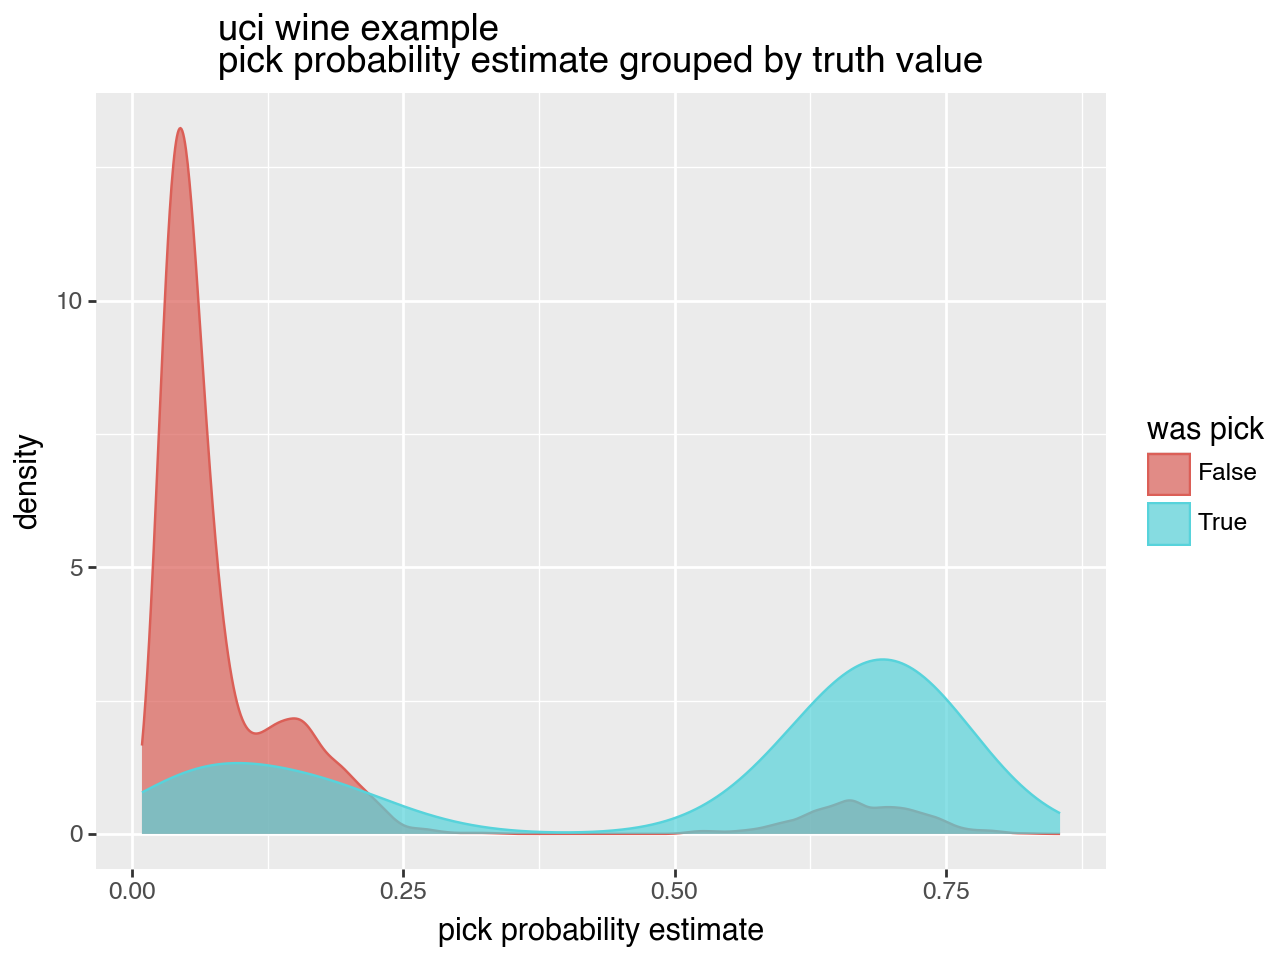

In [29]:
(
    ggplot(
        data=pick_frame,
        mapping=aes(
            x='pick probability estimate',
            color='was pick',
            fill='was pick',
        )
    )
    + geom_density(alpha=0.7)
    + ggtitle(f'{example_name}\npick probability estimate grouped by truth value')
)

<Figure size 640x480 with 0 Axes>

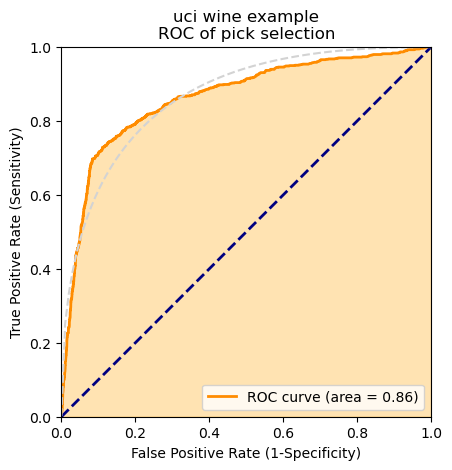

0.863436375

In [30]:
plot_roc(
    prediction=pick_frame['pick probability estimate'],
    istrue=pick_frame['was pick'],
    ideal_line_color='lightgrey',
    title=f'{example_name}\nROC of pick selection',
)

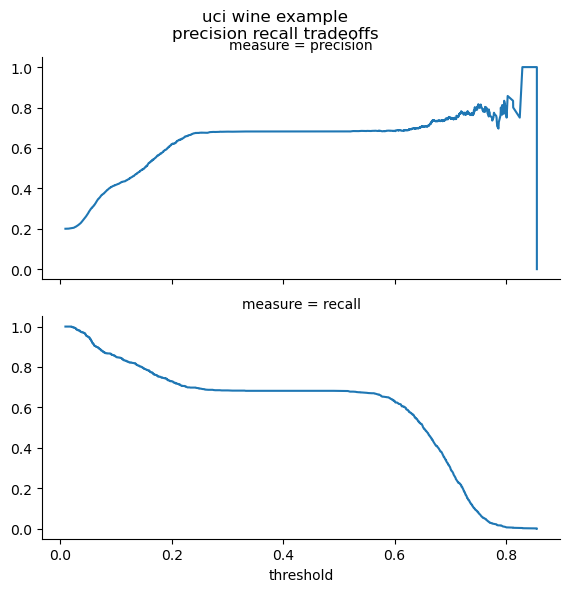

In [31]:
threshold_plot(
    pick_frame,
    pred_var='pick probability estimate',
    truth_var='was pick',
    plotvars=("precision", "recall"),
    title=f'{example_name}\nprecision recall tradeoffs',
)

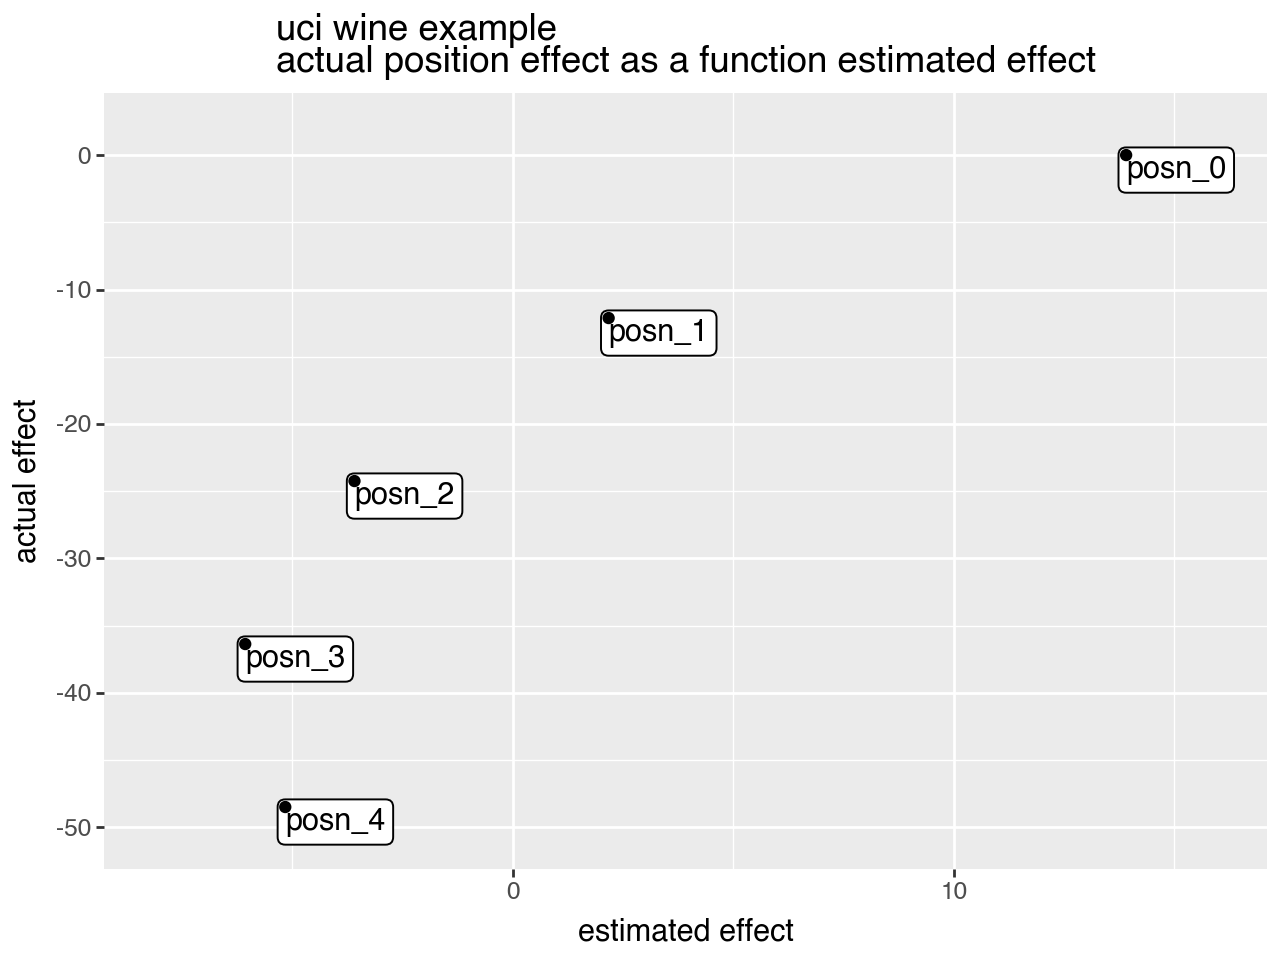

In [32]:
(
    ggplot(
        data=position_effects_frame,
        mapping=aes(
            x='estimated effect', 
            y='actual effect',
            label='position',
            ),
    )
    + geom_label(ha='left', va='top')
    + xlim((np.min(position_effects_frame['estimated effect']) - 2, np.max(position_effects_frame['estimated effect']) + 2))
    + ylim((np.min(position_effects_frame['actual effect']) - 2, np.max(position_effects_frame['actual effect']) + 2))
    + geom_point()
    + ggtitle(f'{example_name}\nactual position effect as a function estimated effect')
)

In [33]:
score_compare_frame = pd.DataFrame({
    'original score': features_scores['score'],
    'learned score': estimated_scores['estimated score'],
})

In [34]:
score_compare_frame.head()

,original score,learned score
0,10.177865,14.212840
1,9.856330,13.584577
2,10.241983,14.145111
3,12.145984,14.571516
4,10.177865,14.212840


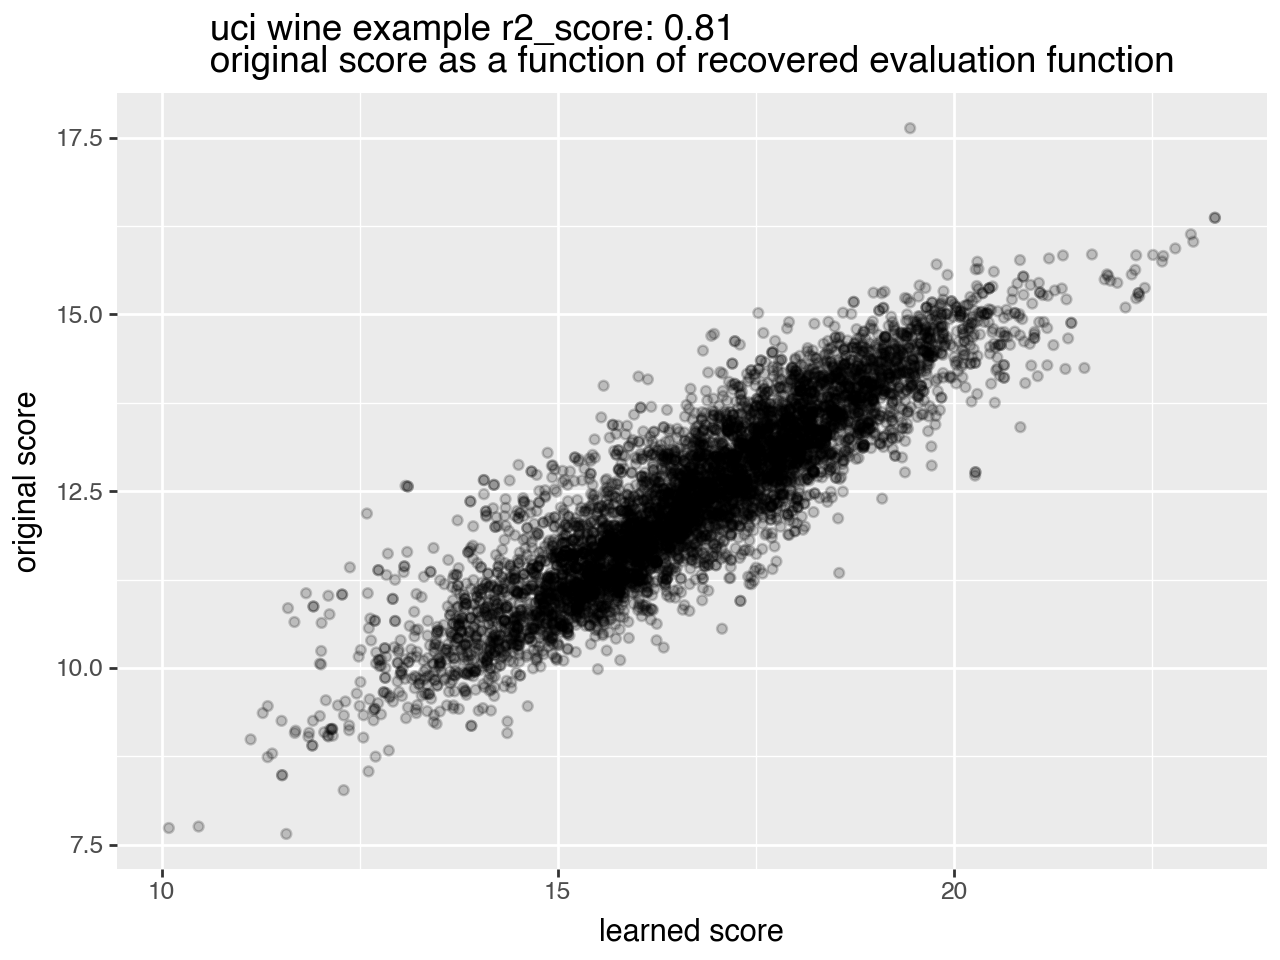

In [35]:
lin_model = LinearRegression()
lin_model.fit(
    score_compare_frame.loc[:, ['learned score']],
    score_compare_frame.loc[:, 'original score'],
)
r2_all = r2_score(
    y_true=score_compare_frame.loc[:, 'original score'],
    y_pred=lin_model.predict(score_compare_frame.loc[:, ['learned score']]),
)
(
    ggplot(
        data=score_compare_frame,
        mapping=aes(x='learned score', y='original score'),
    )
    + geom_point(alpha=0.2)
    + ggtitle(f'{example_name} r2_score: {r2_all:.2f}\noriginal score as a function of recovered evaluation function')
)

In [36]:
observed_ids = set(observations.loc[:, [c for c in observations.columns if c.startswith('item_id_')]].values.flatten())
unobserved_ids = [i for i in range(features_frame.shape[0]) if i not in observed_ids]

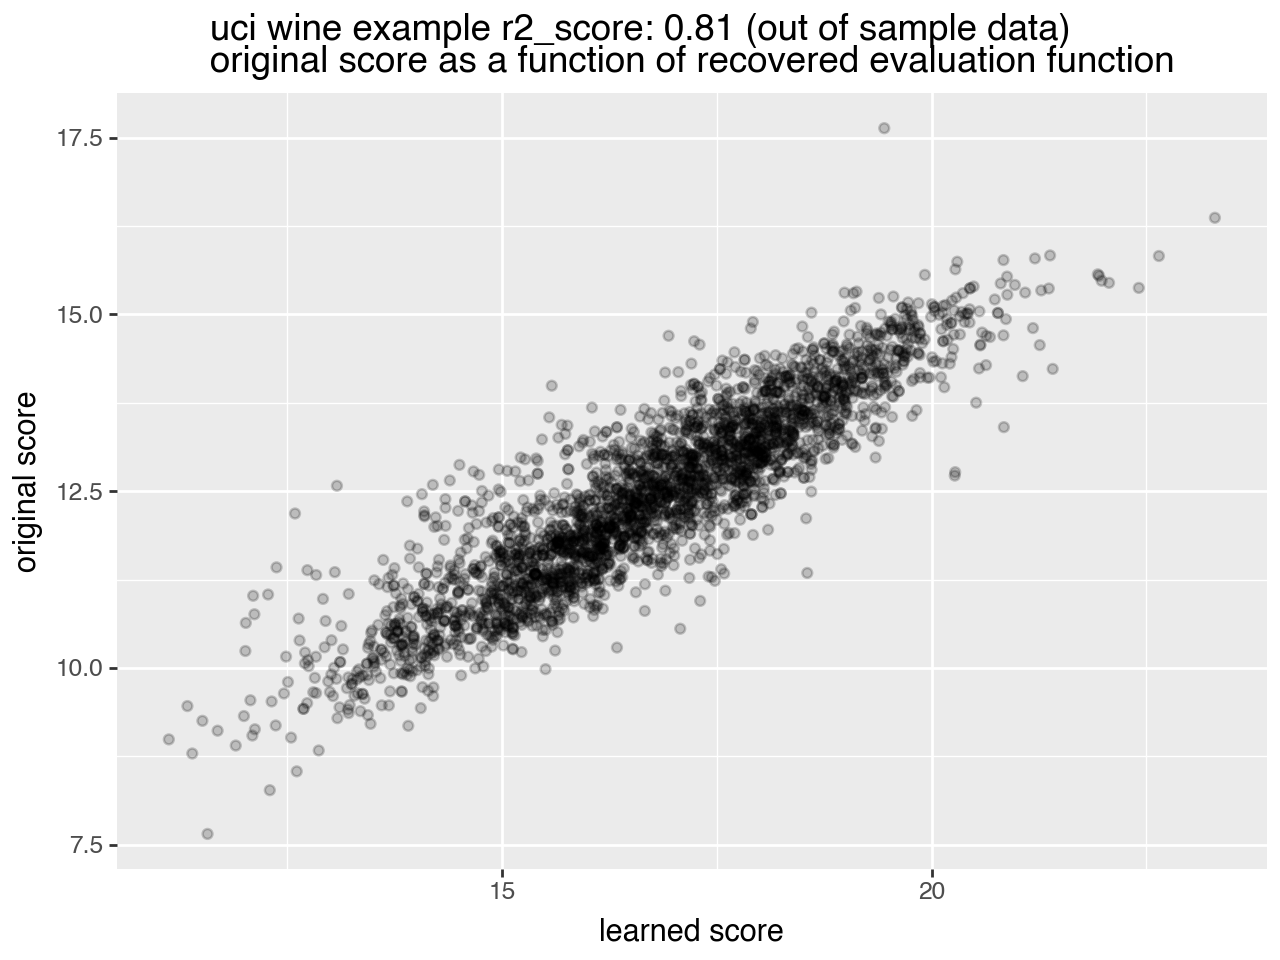

In [37]:
if len(unobserved_ids) > 10:
    score_compare_frame_test = score_compare_frame.loc[unobserved_ids, :].reset_index(drop=True, inplace=False)
    lin_model_test = LinearRegression()
    lin_model_test.fit(
        score_compare_frame_test.loc[:, ['learned score']],
        score_compare_frame_test.loc[:, 'original score'],
    )
    r2_out_of_sample = r2_score(
        y_true=score_compare_frame_test.loc[:, 'original score'],
        y_pred=lin_model_test.predict(score_compare_frame_test.loc[:, ['learned score']]),
    )
    (
        ggplot(
            data=score_compare_frame_test,
            mapping=aes(x='learned score', y='original score'),
        )
        + geom_point(alpha=0.2)
        + ggtitle(f'{example_name} r2_score: {r2_out_of_sample:.2f} (out of sample data)\noriginal score as a function of recovered evaluation function')
    ).show()

